*Luka Alhonen*
# Exercise 5

## 1. Non-programming Tasks

### 1.1 Learning diary

#### Algorithmic Evaluation

In order to determine whether a IoT sensing pipeline is working correctly we have to define criteria to evaluate the pipeline. One of these criteria is Algorithmic Criteria, which evaluates the outputs of the sensing pipeline. This is performed using methods such as classification, regression, model fit measures and measures of uncertainty. Most commonly, classification and regression metrics from ML literature are used to evaluate the correctness of the output. Common classification metrics used are precision, recall and F1-Score. These metrics can be combined into a so-called confusion matrix, which displays the different types of misclassifications. Since regression models do not deal with fixed outcomes they cannot use accuracy as a metric and must therefore be evaluated by examining the error of individual predictions.

#### Privacy Attacks

A privacy attack, as the name suggests is essentially a type of attack where an adversary compromises the privacy of the victim. This can for example be a disclosure attack or a reconstruction attack. In a disclosure attack, the adversary attempts to make sensitive information known. The most common forms of disclosure are Membership Disclosure; whether or not an individual belongs to a dataset, Attribute Disclosure; identifying sensitive information using other parameters without knowledge of an individual’s records, Identity Disclosure; Identification of an individual using attributes linked to specific personal identities. This type of attack can either be performed interactively if the target is an active system or non-interactively if the target is an existing dataset.

## 2. Programming Tasks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from mlxtend.evaluate import mcnemar_table, mcnemar
from mlxtend.plotting import checkerboard_plot

In [2]:
df = pd.read_csv('task5.csv')


### 2.1 DS4IoT Evaluation

#### a) 

To evaluate the performance of the two clustering algorithms I plotted the clusters (each with a different color) and then the ground truth (aggregate of temperature and pm using mean) of each cluster as a star of the same color as the cluster. 

As one can see from plots 1.1 and 1.2, the only difference between the two algorithms is that clusters 2 and 3 are switched. Because of this, Agglomerative Clustering is more accurate. Looking at plot 1.2, we can see that clusters 0, 2 and 3 are closest to the ground truth.

In [3]:
# Aggregate temp and pm by station id using median
grouped_df = df.groupby('id')[['temperature', 'pm']].median()

In [21]:
X = grouped_df.values

# Kmeans
kmeans = KMeans(n_clusters=6, random_state=1234).fit(X)
grouped_df['kmeans_cluster'] = kmeans.labels_

# Agglomerative
agg_clustering = AgglomerativeClustering(n_clusters=6).fit(X)
grouped_df['agg_cluster'] = agg_clustering.labels_

In [22]:
# Ground truth
gt_df = df.groupby('area')[['temperature', 'pm']].mean()
print(grouped_df)

    temperature      pm  kmeans_cluster  agg_cluster
id                                                  
0        21.000  34.985               0            0
1        20.955  33.995               0            0
2        20.530  33.960               0            0
3        22.125  33.455               0            0
4        20.900  34.125               0            0
5        20.455  33.980               0            0
6        22.210  33.560               0            0
7        20.990  33.995               0            0
8        20.510  33.960               0            0
9        22.300  33.510               0            0
10       19.025  35.275               2            3
11       18.945  33.450               2            3
12       18.420  33.455               2            3
13       20.120  33.070               2            3
14       18.980  33.480               2            3
15       18.485  33.490               2            3
16       20.230  33.065               0       

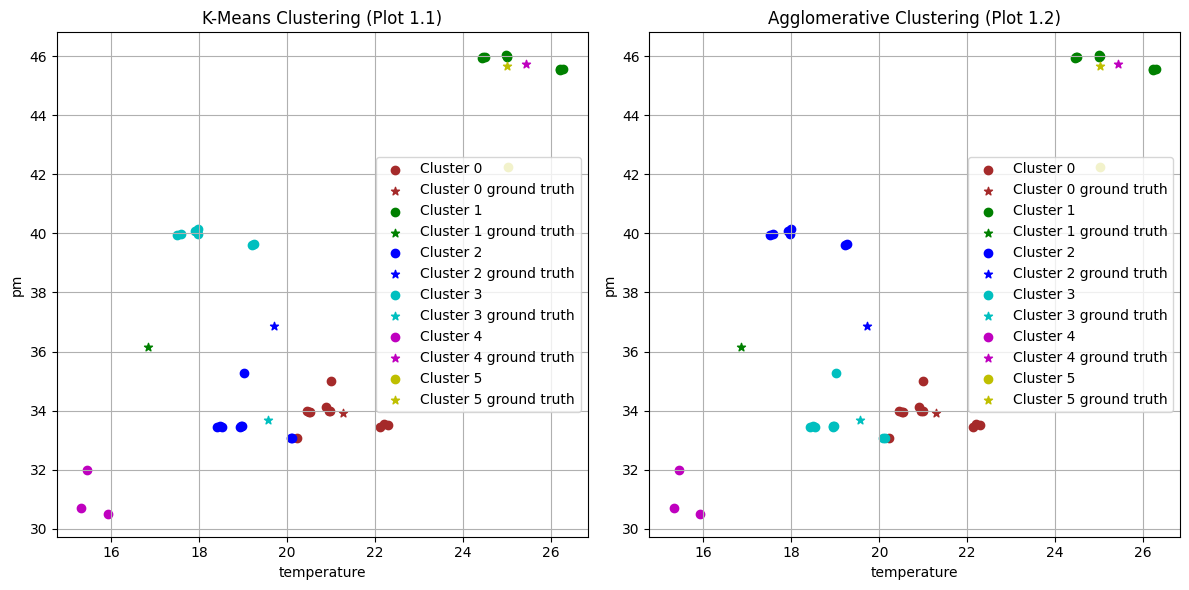

In [23]:
colors = ['brown', 'g', 'b', 'c', 'm', 'y']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot K-Means clusters
for i in range(6):
    cluster = grouped_df[grouped_df['kmeans_cluster'] == i]
    gt = gt_df[gt_df.index == i]
    axs[0].scatter(cluster['temperature'], cluster['pm'], c=colors[i], label=f'Cluster {i}')
    axs[0].scatter(gt['temperature'], gt['pm'], c=colors[i], marker='*', label=f'Cluster {i} ground truth')

axs[0].set_title('K-Means Clustering (Plot 1.1)')
axs[0].set_xlabel('temperature')
axs[0].set_ylabel('pm')
axs[0].legend()
axs[0].grid()

# Plot Agglomerative clusters
for i in range(6):
    cluster = grouped_df[grouped_df['agg_cluster'] == i]
    gt = gt_df[gt_df.index == i]
    axs[1].scatter(cluster['temperature'], cluster['pm'], c=colors[i], label=f'Cluster {i}')
    axs[1].scatter(gt['temperature'], gt['pm'], c=colors[i], marker='*', label=f'Cluster {i} ground truth')

axs[1].set_title('Agglomerative Clustering (Plot 1.2)')
axs[1].set_xlabel('temperature')
axs[1].set_ylabel('pm')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

#### b)

As is evident from the checkerboard plots (Plot 2 and Plot 3), as well as the other evaluation metrics, the difference between the two algorithms is not large, however the only really difference is the fact that Agglomerative Clustering seems to be more accurate in correctly labeling cluster 3.

In [24]:
# Preprocessing

grouped_df_reset = grouped_df.reset_index()

df_merged = df.merge(grouped_df_reset[['id', 'kmeans_cluster', 'agg_cluster']], on='id', how='left')
df_merged.set_index('timestamp', inplace=True)
print(df_merged)

           id  temperature     pm  longitude  latitude  area  kmeans_cluster  \
timestamp                                                                      
0           0        21.47  44.62       0.37      9.90     0               0   
1           0        21.16  44.13       0.37      9.90     0               0   
2           0        21.17  38.48       0.37      9.90     0               0   
3           0        20.36  55.86       0.37      9.90     0               0   
4           0        20.99  16.01       0.37      9.90     0               0   
...        ..          ...    ...        ...       ...   ...             ...   
115        39        26.30  45.30       8.31      3.84     4               1   
116        39        26.02  45.02       8.31      3.84     4               1   
117        39        26.51  45.51       8.31      3.84     4               1   
118        39        26.20  46.20       8.31      3.84     4               1   
119        39        25.94  45.94       

In [25]:
# True labels
y_true = df_merged['area']

# Predicted labels
y_pred_kmeans = df_merged['kmeans_cluster']
y_pred_agg = df_merged['agg_cluster']

In [26]:
# Kmeans Clustering

precision_k, recall_k, fscore_k, support_k = precision_recall_fscore_support(y_true, y_pred_kmeans)

# Print metrics
print('KMeans - Precision: ', precision_k)
print('KMeans - Recall: ', recall_k)
print('KMeans - F-score: ', fscore_k)
print('KMeans - Support: ', support_k)

# Confusion matrix
cm_k = confusion_matrix(y_true, y_pred_kmeans)
print('\nK-Means - Confusion matrix:\n', cm_k)

# Checkerboard plot
plt.figure()
checkerboard_plot(cm_k, 
                  figsize=(6,6), 
                  fmt='%d', 
                  col_labels=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3', 'Predicted 4', 'Predicted 5'], 
                  row_labels=['Area 0', 'Area 1', 'Area 2', 'Area 3', 'Area 4', 'Area 5'])
plt.title('K-Means Confusion Matrix (Plot 2)', y=1.1)
plt.show()


KMeans - Precision:  [0.45454545 0.         0.         0.         0.         1.        ]
KMeans - Recall:  [1.         0.         0.         0.         0.         0.16666667]
KMeans - F-score:  [0.625      0.         0.         0.         0.         0.28571429]
KMeans - Support:  [ 600  840  720 1440  480  720]

K-Means - Confusion matrix:
 [[ 600    0    0    0    0    0]
 [   0    0    0  480  360    0]
 [ 360    0    0  360    0    0]
 [ 360    0 1080    0    0    0]
 [   0  480    0    0    0    0]
 [   0  600    0    0    0  120]]


<Figure size 640x480 with 0 Axes>

In [10]:
# Agglomerative Clustering

precision_a, recall_a, fscore_a, support_a = precision_recall_fscore_support(y_true, y_pred_agg)

# Print metrics
print('Agg - Precision: ', precision_a)
print('Agg - Recall: ', recall_a)
print('Agg - F-score: ', fscore_a)
print('Agg - Support: ', support_a)

# Confusion matrix
cm_a = confusion_matrix(y_true, y_pred_agg)
print(cm_a)

# Checkerboard plot
plt.figure()
checkerboard_plot(cm_a, 
                  figsize=(6,6), 
                  fmt='%d', 
                  col_labels=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3', 'Predicted 4', 'Predicted 5'], 
                  row_labels=['Area 0', 'Area 1', 'Area 2', 'Area 3', 'Area 4', 'Area 5'])
plt.title('Agglomerative Clustering Confision Matrix (Plot 3)', y=1.1)
plt.show()

Agg - Precision:  [0.38461538 0.         0.42857143 0.         0.         1.        ]
Agg - Recall:  [1.         0.         0.5        0.         0.         0.16666667]
Agg - F-score:  [0.55555556 0.         0.46153846 0.         0.         0.28571429]
Agg - Support:  [ 600  840  720 1440  480  720]
[[600   0   0   0   0   0]
 [  0   0 480 360   0   0]
 [360   0 360   0   0   0]
 [600   0   0   0 840   0]
 [  0 480   0   0   0   0]
 [  0 600   0   0   0 120]]


<Figure size 640x480 with 0 Axes>